## Incremental learning with River

In [68]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
import sys
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score
from scipy.stats import mode
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from scipy.spatial.distance import mahalanobis
import random
sys.path.append('.\\..\\..\\..\\Chapter2-Z24-dataset')
import random
from river import anomaly
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from predict import binarize
import os

In [46]:
X_train = np.load("C:\\Users\\amroa\\Documents\\thesis\\X_train.npy")
labels_train = np.load("C:\\Users\\amroa\\Documents\\thesis\\labels_train.npy")
X_test = np.load("C:\\Users\\amroa\\Documents\\thesis\\X_test.npy")
labels_test = np.load("C:\\Users\\amroa\\Documents\\thesis\\labels_test.npy")

In [47]:
X_train.shape, \
X_test.shape

((544, 906), (68, 906))

In [48]:
# feature selection (see previous part -- xgboost binary)
subset_indices =  [191, 374, 328, 673]

In [49]:
def plot_roc(true_y, y_prob, method_name):
    fpr, tpr, _ = roc_curve(true_y, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2 
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for {method_name}')
    plt.legend(loc="lower right")
    plt.show()

### Recreate original dataset

In [50]:
test_indices=  np.array([])
train_indices=  np.array([])

for i in range(17):
    random.seed(i)
    nbr_splits = 36 #  recall 612/17 = 36, where 612 = total nbr of epochs, 17 is nbr of scenarios
    test_split = 4
    test_indices_temp = np.array(random.sample(range(nbr_splits), test_split))
    test_indices = np.append(test_indices, i*nbr_splits + test_indices_temp)
    train_indices = np.append(train_indices,  i*nbr_splits+ np.array([x for x in range(nbr_splits) if x not in test_indices_temp]))

print(len(train_indices))

544


In [51]:
train_ctr = 0
test_ctr = 0
data_all = []
labels_all = []
for i in range(612):
    if i in train_indices:
        data_all.append(X_train[train_ctr])
        labels_all.append(labels_train[train_ctr])
        train_ctr += 1
    elif i in test_indices:
        data_all.append(X_test[test_ctr])
        labels_all.append(labels_test[test_ctr])
        test_ctr += 1

In [52]:
y_all = binarize(labels_all) # is the labels of all instances 
data_all = np.array(data_all) # are all the instances

In [53]:
data_all_top = data_all[:, subset_indices] 
healthy_data = data_all_top[y_all == 0]
damage_data = data_all_top[y_all == 1]
healthy_data.shape, damage_data.shape

((288, 4), (324, 4))

In [54]:
# for occ labels are defined differently
damage_labels  = -1*np.ones(damage_data.shape[0])
healthy_labels =    np.ones(healthy_data.shape[0])

In [55]:
def fill_between_plot(x_range, average_obs, std_obs, label, title):
    plt.figure(figsize=(8, 5))
    colors = ['blue', 'cyan', 'red', 'green']
    for idx, (avg_obs, std_ob) in enumerate(zip(average_obs, std_obs)):
        plt.plot(x_range, avg_obs, color = colors[idx], label=label)
        plt.fill_between(x_range, avg_obs - std_ob, avg_obs + std_ob, color=colors[idx], alpha=0.5, label='1 std dev')
    plt.title(title)
    plt.xlabel("Healthy population sample size")
    plt.ylabel(label)
    plt.legend()
    plt.show()

In [56]:
def fill_between_plot_diffx(x_ranges, average_obs, std_obs, label, title, labely):
    plt.figure(figsize=(8, 5))
    colors = ['blue', 'cyan', 'red', 'green']
    
    # Ensure that x_ranges, average_obs, and std_obs have the same length
    if not (len(x_ranges) == len(average_obs) == len(std_obs)):
        raise ValueError("Length of x_ranges, average_obs, and std_obs must be the same")

    for idx, (x_range, avg_obs, std_ob) in enumerate(zip(x_ranges, average_obs, std_obs)):
        plt.plot(x_range, avg_obs, color=colors[idx % len(colors)], label=f'{label[idx]}')
        plt.fill_between(x_range, avg_obs - std_ob, avg_obs + std_ob, color=colors[idx % len(colors)], alpha=0.5, label='1 std dev')
    
    plt.title(title)
    plt.xlabel("Healthy population sample size")
    plt.ylabel(labely)
    plt.legend()
    plt.show()

### Test and training dataset

In [57]:
healthy_data.shape, damage_data.shape

((288, 4), (324, 4))

In [58]:
random.seed(42)
test_size = 0.25
np.random.seed(42)
healthy_idx = np.concatenate([[i*36 + np.random.choice(36, size=int(36*(1-test_size)), replace=False)] for i in range(8)], axis=1)[0]
print(healthy_idx)
healthy_train = healthy_data[np.sort(healthy_idx), :]
healthy_test = healthy_data[np.sort(np.array([i for i in range(healthy_data.shape[0]) if i not in healthy_idx])), :]

dam_test = damage_data
healthy_train.shape, dam_test.shape, healthy_test.shape

[ 35  13  26  30  16  31  21  12   8  17   9  34   0   4  29  15  19   5
  11   1  24   2  33   3  32  23  27  51  52  40  45  64  57  46  41  54
  48  61  58  65  36  62  71  59  43  47  67  50  55  37  69  68  66  49
  73  82  76 104  77  74 102 106  95  83  78  88  72  93  90  91  80  96
  99 107  84 100  92  98  94 103  79 118 136 111 127 128 120 113 139 143
 117 134 125 124 121 122 132 126 141 129 138 137 110 142 131 133 130 123
 170 174 164 146 151 159 144 161 165 152 177 163 169 157 168 160 155 149
 167 153 145 162 172 171 176 154 158 202 213 183 190 195 200 215 205 212
 197 208 207 214 181 186 193 204 211 196 199 210 201 194 203 191 189 198
 228 231 235 250 222 223 225 229 240 218 233 237 244 224 249 230 239 251
 246 220 242 232 226 243 219 238 221 277 275 274 255 257 273 272 266 282
 285 264 256 263 265 276 253 268 287 267 279 254 261 278 262 281 280 269]


((216, 4), (324, 4), (72, 4))

In [59]:
test_data = np.vstack([healthy_test, dam_test])
test_labels = np.repeat([1, -1], [healthy_test.shape[0], dam_test.shape[0]]).astype(int)

train_data = healthy_train
train_labels = np.full(train_data.shape[0], 1).astype(int)

In [60]:
pca = PCA(n_components=3)
sc = StandardScaler()

sc.fit(healthy_data[0:36])
pca.fit(healthy_data[0:36])

PCA(n_components=3)

In [17]:
damage_data.shape

(324, 4)

## Visualization (static)

### Time color-coded - static

In [222]:
import matplotlib
matplotlib.use('Qt5Agg')
data_plot = np.vstack([healthy_data, damage_data])
data_plot = pca.transform(data_plot)

plt.figure(figsize=(10, 6))
plt.scatter(data_plot[:, 0], data_plot[:, 1], c=range(len(data_plot)), cmap='viridis')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(label='Time')
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')

plt.show()

(612, 4)


In [149]:
plt.figure(figsize=(10, 6))
plt.scatter(data_plot[:, 1], data_plot[:, 2], c=range(len(data_plot)), cmap='viridis')
plt.xlabel('PC 2')
plt.ylabel('PC 3')
plt.colorbar(label='Time')
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')

plt.show()

In [150]:
plt.figure(figsize=(10, 6))
plt.scatter(data_plot[:, 0], data_plot[:, 2], c=range(len(data_plot)), cmap='viridis')
plt.xlabel('PC 1')
plt.ylabel('PC 3')
plt.colorbar(label='Time')
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')

plt.show()

### Healthy vs damaged scatter plots - static

In [153]:
plt.figure(figsize=(10, 6))
plt.scatter(data_plot[healthy_data.shape[0]:, 0], data_plot[healthy_data.shape[0]:, 2],  color='red')
plt.scatter(data_plot[:healthy_data.shape[0], 0], data_plot[:healthy_data.shape[0], 2], color='blue')
plt.xlabel('PC 1')
plt.ylabel('PC 3')
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')

plt.show()

In [154]:
plt.figure(figsize=(10, 6))
plt.scatter(data_plot[healthy_data.shape[0]:, 1], data_plot[healthy_data.shape[0]:, 2],  color='red')
plt.scatter(data_plot[:healthy_data.shape[0], 1], data_plot[:healthy_data.shape[0], 2], color='blue')
plt.xlabel('PC 2')
plt.ylabel('PC 3')
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')

plt.show()

In [155]:
plt.figure(figsize=(10, 6))
plt.scatter(data_plot[healthy_data.shape[0]:, 0], data_plot[healthy_data.shape[0]:, 1],  color='red')
plt.scatter(data_plot[:healthy_data.shape[0], 0], data_plot[:healthy_data.shape[0], 1], color='blue')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')

plt.show()

In [223]:
np.save("data_plot.npy", data_plot)

### Healthy vs damaged - animated

In [233]:
import matplotlib.animation as animation
matplotlib.use('Qt5Agg')  # 'Qt5Agg', 'Qt4Agg', 'GTK3Agg', 'WXAgg'

data_plot = np.load("data_plot.npy")
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')
ax.set_xlim(data_plot[:, 0].min() - 1, data_plot[:, 0].max() + 1)
ax.set_ylim(data_plot[:, 1].min() - 1, data_plot[:, 1].max() + 1)
current_num_text = ax.text(0.05, 0.95, '', transform=ax.transAxes)

# Animation function for showing scatter points one by one
def update(num):
    point = ax.scatter(data_plot[num, 0], data_plot[num, 1], color='blue' if num < healthy_data.shape[0] else 'red', marker = 'o', s=30)
    current_num_text.set_text(f'Instance: {num}')
    return point, current_num_text

# Creating the new animation
ani = animation.FuncAnimation(fig, update, frames=data_plot.shape[0], interval=10, blit=True)
ani.save('pc1pc2animation.gif', writer='pillow')
plt.close()  # Close the plot to finalize the animation file creation

In [234]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 3')
ax.set_title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')
ax.set_xlim(data_plot[:, 0].min() - 1, data_plot[:, 0].max() + 1)
ax.set_ylim(data_plot[:, 2].min() - 1, data_plot[:, 2].max() + 1)
current_num_text = ax.text(0.05, 0.95, '', transform=ax.transAxes)

# Animation function for showing scatter points one by one
def update(num):
    point = ax.scatter(data_plot[num, 0], data_plot[num, 2], color='blue' if num < healthy_data.shape[0] else 'red', marker = 'o', s=30)
    current_num_text.set_text(f'Instance: {num}')
    return point, current_num_text

# Creating the new animation
ani = animation.FuncAnimation(fig, update, frames=data_plot.shape[0], interval=10, blit=True)
ani.save('pc1pc3animation.gif', writer='pillow')
plt.close()  # Close the plot to finalize the animation file creation

Traceback (most recent call last):
  File "c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py", line 309, in process
    func(*args, **kwargs)
  File "c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\animation.py", line 908, in _start
    self.event_source.add_callback(self._step)
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'add_callback'


Traceback (most recent call last):
  File "c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py", line 309, in process
    func(*args, **kwargs)
  File "c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\animation.py", line 908, in _start
    self.event_source.add_callback(self._step)
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'add_callback'


In [232]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('PC 2')
ax.set_ylabel('PC 3')
ax.set_title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')
ax.set_xlim(data_plot[:, 1].min() - 1, data_plot[:, 1].max() + 1)
ax.set_ylim(data_plot[:, 2].min() - 1, data_plot[:, 2].max() + 1)
current_num_text = ax.text(0.05, 0.95, '', transform=ax.transAxes)

# Animation function for showing scatter points one by one
def update(num):
    point = ax.scatter(data_plot[num, 1], data_plot[num, 2], color='blue' if num < healthy_data.shape[0] else 'red', marker = 'o', s=30)
    current_num_text.set_text(f'Instance: {num}')
    return point, current_num_text

# Creating the new animation
ani = animation.FuncAnimation(fig, update, frames=data_plot.shape[0], interval=10, blit=True)
ani.save('pc2pc3animation.gif', writer='pillow')
plt.close()  # Close the plot to finalize the animation file creation

Traceback (most recent call last):
  File "c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py", line 309, in process
    func(*args, **kwargs)
  File "c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\animation.py", line 908, in _start
    self.event_source.add_callback(self._step)
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'add_callback'


In [238]:
corr = np.corrcoef(data_all_top, rowvar=False)
print(corr.shape)

mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='viridis', vmax=1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.show()

(4, 4)


In [18]:
param_grid_occ_svm = {
    'nu': [0.01, 0.1, 0.2], 
    'gamma': ['scale', 'auto'],
    'tol': [1e-3, 1e-2, 1e-1],
    'kernel': ['rbf']
} # rbf by default

### Story
Train OCC on first health scenario, then data comes one by one. Each data point that arrives is added to the support of the OCC. The OCC detects weather each new arriving point is anomalous or not. After accumulation of all healthy points into the support occurs, we test on all damage data to see whether it will report healthy or damaged. Note, to be realistic the support should be implemented incrementally, i.e. naively storing all arriving instances is not realistic.   

In [61]:
healthy_data_top = pca.transform(sc.transform(healthy_data))
damage_data_top  = pca.transform(sc.transform(damage_data))

healthy_data.shape, damage_data.shape, healthy_data_top.shape, damage_data_top.shape

((288, 4), (324, 4), (288, 3), (324, 3))

In [62]:
print(pca.components_)

[[-0.05803742 -0.99713111  0.04461419  0.01925557]
 [-0.04742084 -0.02222721 -0.13119466 -0.98997231]
 [ 0.62600635 -0.0696001  -0.77316884  0.07403934]]


In [20]:
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib.sankey import Sankey
import matplotlib.pyplot as plt
components = pca.components_
n_features = components.shape[1]
n_components = components.shape[0]
import plotly.graph_objects as go

# Example PCA components for illustration
pca_components_example = pca.components_

# Define nodes (PCA components and original features)
node_labels = ['PCA 1', 'PCA 2', 'PCA 3', 'fft_range_50', 'rel_pos_psd', 'coeffs_psd', 'rel_pos_trans']

# Define links
source_nodes = []
target_nodes = []
values = []

for i in range(n_components):
    for j in range(n_features):
        source_nodes.append(i)
        target_nodes.append(n_components + j)
        values.append(abs(pca_components_example[i, j]))

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = node_labels,
    ),
    link = dict(
      source = source_nodes, 
      target = target_nodes,
      value = values
    ))])

fig.update_layout(title_text="PCA Component Contributions to Features", font_size=20)
fig.show()



### Base stream learner

In [169]:
import copy
class StreamLearning:
    def __init__(self, h_data, d_data, clf, min_points_for_retraining = 3, reset_clf = False):
        self.h_data = h_data # healthy state data
        self.d_data = d_data # damage state data
        self.clf = clf       # the OCC
        self.ctr = 36        # current healthy instance (first health scenario is used for initialization of the model) 
        self.an_inst = []    # stores the indices of the anomalous instances
        self.d_preds = []
        self.h_preds = []
        self.d_pred_proba = []
        self.h_pred_proba = []
        self.all_data = np.vstack((self.h_data, self.d_data))
        self.val_scores = []
        self.min_points_for_retraining = min_points_for_retraining
        self.reset_clf = reset_clf # whether or not to reset classifier on anomaly detection
        self.base_clf = copy.deepcopy(clf)

    def support_include(self): # include into the support
        self.clf.update(self.all_data[self.ctr])
        self.ctr += 1

    def is_cur_anomaly(self):
        cur_inst = self.all_data[self.ctr]
        self.h_pred_proba.append(self.clf.predict_proba(cur_inst)[0])
        if self.clf.predict(cur_inst)[0] < 0:
            # false positive found, add it to this list
            self.an_inst.append(self.ctr)
            # reset model only if reset set to true
            if self.reset_clf:
                self.retrain(self.ctr)

    def retrain(self, anomaly_idx):
        # when anomaly encountered retrain on last 36 points
        self.clf = copy.deepcopy(self.base_clf)
        # make sure to not sample across boundaries
        scenario_of_anomaly_idx = int(anomaly_idx/36)
        previous_scenario = scenario_of_anomaly_idx - 1
        is_first_instance_in_scenario = int(anomaly_idx % 36) # is the anomalous instance, the first instance in its state?
        current_or_previous_scenario =  previous_scenario if is_first_instance_in_scenario == 0 else scenario_of_anomaly_idx # if yes, use the previous scenario as we have not accumulated enough of the current scenario
        # for the covariance matrix to be inverted inside predict of GaussianIncremental, we need at least three points
        nbr_points = anomaly_idx - current_or_previous_scenario*36
        # for cases where we need to initialize with at least self.min_points_for_training
        for j in range(max(1, int(self.min_points_for_retraining / nbr_points))):
            for i in range(current_or_previous_scenario*36, anomaly_idx):
                self.clf.update(self.h_data[i])
        remainder = self.min_points_for_retraining % nbr_points    
        if (remainder) != 0:
            #print("Adding more points to prevent singularity in OCC")
            for j in range(remainder):
                self.clf.update(self.h_data[anomaly_idx - 1 - j]) # just add more of the last points

    def final_evaluation(self):
        # loop until anomaly is detected
        p_score = self.clf.predict_proba(self.all_data[self.ctr])[0]
        score = self.clf.predict(self.all_data[self.ctr])[0]
        self.first_dam_idx = 0 # how many points do we need to wait until damage is detected (if 1st dam. index detected, it is 0)
        while score > 0 and self.ctr < self.all_data.shape[0]:
            self.h_pred_proba.append(p_score) 
            # line above implies that h_pred_proba is no longer simply of length h_data, 
            # but can be slightly longer depending on how long it takes for the clf to realize it is in the damage zone
            self.support_include()
            self.first_dam_idx = self.first_dam_idx + 1
            p_score = self.clf.predict_proba(self.all_data[self.ctr])[0]
            score = self.clf.predict(self.all_data[self.ctr])[0]

        # compute preds (for final evaluation). Note: avoid using self.h_preds since it is done post-facto
        self.d_preds = self.clf.predict(self.d_data[self.first_dam_idx:]) # since some of the damage may have been seen (i.e. included to the support), we don't consider them for test
        self.h_preds = self.clf.predict(self.h_data)
        self.d_pred_proba = self.clf.predict_proba(self.d_data[self.first_dam_idx:])

    def cross_validate(self):
        # call  loop with different cuts used for cross-validation
        for i in range(1, 8): # we don't cross validate on first one
            self.loop(i)

    def init_clf(self):
        # initialize 
        for i in range(36):
            self.clf.update(self.h_data[i])

    def loop(self, i = -1):
        if i != -1:
            cv_set_len = 36 # size of CV set
            n_iters = self.h_data.shape[0] - self.ctr - cv_set_len
            self.cv_set = self.h_data[i*36:(i+1)*36]
            self.all_data = np.vstack((self.all_data[:i*36], self.all_data[(i+1)*36:])) 
        else:
            n_iters = self.h_data.shape[0] - self.ctr
            self.cv_set = None

        # initialize the model
        self.init_clf()
        
        # simulate data intake
        for i in range(n_iters):
            self.is_cur_anomaly()
            self.support_include()
        
        # find validation score
        if not(self.cv_set is None):
            pred_val = np.array(self.clf.predict(self.cv_set)).reshape(-1, 1)
            acc_val  = np.sum(pred_val > 0)/len(pred_val) 
            self.val_scores.append(acc_val)

        # the final evaluation
        self.final_evaluation()

In [64]:
def print_metrics(sl: StreamLearning):
    print("cor_d_preds", np.sum(np.array(sl.d_preds) < 0), "cor_h_preds (do not use)", np.sum(np.array(sl.h_preds) > 0), "d_pred_len", len(sl.d_preds), "h_pred_len", len(sl.h_preds))
    print("fp count", len(sl.an_inst), "first damage index", sl.first_dam_idx)

### Gaussian ellipsoid

In [82]:
from scipy.spatial import distance
from scipy.stats import chi2

class IncrementalGaussianFitter:
    def __init__(self):
        self.mean = np.array([0.0, 0.0, 0.0])
        self.covariance = np.eye(3)
        self.count = 0

    def update(self, new_point):
        self.count += 1
        old_mean = self.mean.copy()
        self.mean += (new_point - self.mean) / self.count
        self.covariance = ((self.count - 1) * self.covariance + 
                           np.outer(new_point - self.mean, new_point - self.mean)) / self.count

    def get_mean(self):
        return self.mean

    def get_covariance(self):
        return self.covariance
    
    def predict_proba(self, points):
        if points.ndim == 1:
            points = np.array([points])
        confidence_level=0.95
        threshold = chi2.ppf(confidence_level, df=3)  # df=3 for 3 dimensions
        mahalanobis_distances = np.array([distance.mahalanobis(point, self.mean, np.linalg.inv(self.covariance)) 
                                          for point in points])
        #print(self.covariance)
        return (mahalanobis_distances ** 2) - threshold # the higher the more likely an anomaly
    
    # unlike predict_proba, negative corresponds to an anomaly, positive to an inlier
    def predict(self, points):
        if points.ndim == 1:
            points = np.array([points])
        confidence_level=0.95
        threshold = chi2.ppf(confidence_level, df=3)  # df=3 for 3 dimensions
        mahalanobis_distances = np.array([distance.mahalanobis(point, self.mean, np.linalg.inv(self.covariance)) 
                                          for point in points])
        result = mahalanobis_distances ** 2 <= threshold
        result = [2*int(el) - 1  for el in result]
        return result

In [170]:
# only get the CV score, not params in this case 
slg = StreamLearning(healthy_data_top, damage_data_top, IncrementalGaussianFitter())
slg.cross_validate()
np.mean(slg.val_scores) # score: 0.8

0.9246031746031746

In [171]:
# now, without CV and WITHOUT RETRAIN ON ANOMALY, get the performance metrics
slg = StreamLearning(healthy_data_top, damage_data_top, IncrementalGaussianFitter())
slg.loop()
print_metrics(slg)

cor_d_preds 286 cor_h_preds (do not use) 259 d_pred_len 324 h_pred_len 288
fp count 27 first damage index 0


In [172]:
# train without cross validation and WITH RETRAIN ON ANOMALY
slg_reset = StreamLearning(healthy_data_top, damage_data_top, IncrementalGaussianFitter(), reset_clf=True)
slg_reset.loop()
print_metrics(slg_reset)

cor_d_preds 296 cor_h_preds (do not use) 238 d_pred_len 324 h_pred_len 288
fp count 58 first damage index 0


c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\spatial\distance.py:1023: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


In [49]:
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
plt.ion()  # Turn on interactive mode

eigenvalues, eigenvectors = np.linalg.eig(slg.clf.covariance)

# Create a grid for the ellipsoid
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
y = 2*np.sqrt(eigenvalues[0])*np.outer(np.cos(u), np.sin(v)) # two standard deviation to cover 95% of the confidence 
x = 2*np.sqrt(eigenvalues[1])*np.outer(np.sin(u), np.sin(v))
z = 2*np.sqrt(eigenvalues[2])*np.outer(np.ones(np.size(u)), np.cos(v))

# Scale each point by the square root of the corresponding eigenvalue (standard deviation)
for i in range(len(x)):
    for j in range(len(x)):
        [x[i, j], y[i, j], z[i, j]] = np.dot([x[i, j], y[i, j], z[i, j]], eigenvectors) + slg.clf.mean

# Create a 3D plot
fig = plt.figure()


ax = fig.add_subplot(111, projection='3d')
ax.axis('auto')

# Plot the original points
ax.scatter(healthy_data_top[:, 0], healthy_data_top[:, 1], healthy_data_top[:, 2], color='blue', marker='o')
ax.scatter(damage_data_top[:, 0], damage_data_top[:, 1], damage_data_top[:, 2], color='red', marker='o')
ax.set_xlim((-4, 1))
ax.set_ylim((-1, 6))
ax.set_zlim((-5, 3))

# Plot the ellipsoid
ax.plot_surface(x, y, z, color='orange', alpha=0.5)

# Plot principal axes as line segments
for i in range(3):
    axis_start = np.zeros(3) + slg.clf.mean
    axis_end =  eigenvectors[:, i] * np.sqrt(eigenvalues[i])*2 + slg.clf.mean  # Scale factor for visibility
    ax.plot([axis_start[0], axis_end[0]], [axis_start[1], axis_end[1]], [axis_start[2], axis_end[2]], color='green', linewidth=2)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

# save pc1pc2slg, pc2pc3slg, pc1pc3slg
plt.show()

In [57]:
import seaborn as sns
%matplotlib inline
def plot_anom(sl :StreamLearning, title):
    sns.reset_defaults()
    sns.reset_orig()

    plt.figure(figsize=(15, 6))
    nbr_epochs = healthy_data_top.shape[0] - 36 + damage_data_top.shape[0]
    print(nbr_epochs)

    an_scores = np.hstack((sl.h_pred_proba, sl.d_pred_proba)).reshape(-1, 1)
    print(len(range(0, nbr_epochs+1, 36)))
    for i in range(0, nbr_epochs+1, 36):
        plt.axvline(x=i, color='red', linestyle='--', linewidth=0.8)

    # scale and plot the bars
    sc = StandardScaler()
    obs = np.arange(len(an_scores))
    std_entropies = sc.fit_transform(an_scores).flatten()
    
    plt.axvspan(36*7, 36*16, color='yellow', alpha=0.08)
    plt.bar(obs, std_entropies)
    plt.ylim(0, 1.15*max(std_entropies))

    plt.xlabel('Epoch (16,384 samples or 2.7 min per epoch)')
    plt.ylabel('Standardized anomaly score')
    plt.title(title)
    text_pos = [i+18 for i in range(0, nbr_epochs, 36)]
    
    # print title for each state
    for idx, pos in enumerate(text_pos):
        str_capt =  f'DS {idx+2}'
        plt.text(pos, max(std_entropies)*1.1, str_capt, ha='center', color='red')

    plt.show()

In [173]:
def plot_colored_prog(sl: StreamLearning, title: str):
    # standardize anomaly scores of the healthy 
    sch = StandardScaler()
    std_hscores = sch.fit_transform(np.array(sl.h_pred_proba).reshape(-1, 1)).flatten()

    # and the damage data
    scd = StandardScaler()
    std_dscores = scd.fit_transform(np.array(sl.d_pred_proba).reshape(-1, 1)).flatten()

    # Normalize the scores to [0, 1] for color mapping
    norm = MinMaxScaler()
    norm_hscores = norm.fit_transform(std_hscores.reshape(-1, 1)).flatten()
    norm_dscores = norm.fit_transform(std_dscores.reshape(-1, 1)).flatten()

    # Get colors for them based on normalized scores
    reds = sns.color_palette("Reds", n_colors=10)
    blues = sns.color_palette("Blues", n_colors=10)
    
    # Map scores to colors
    h_colors = [blues[int(score * 9)] for score in norm_hscores]
    d_colors = [reds[int(score * 9)] for score in norm_dscores]

    # Combine the colors for plotting
    colors = np.array(h_colors + d_colors)
    fig, ax = plt.subplots(figsize=(15, 6))

    # Setting the bar width to fully cover the plot area
    values = np.ones(len(np.hstack((std_hscores, std_dscores))))
    bar_width = 1.0 / len(values) * len(values)
    fp_idx = np.array(sl.an_inst).astype(int) - 36
    fn_idx = np.where(np.array(sl.d_preds) > 0)[0] + sl.first_dam_idx + sl.h_data.shape[0]
    n_ep = len(colors)

    # Scenario boundaries
    for i in range(0, n_ep+1, 36):
        plt.axvline(x=i, color='gray', alpha = 0.5, linestyle=':', linewidth=1.1, ymax = 0.95)

    # Plotting each bar with the new width
    for i in range(len(values)):
        ax.bar(i, values[i], color=colors[i], width=bar_width, align='edge')
        # Adding a vertical dashed line through the center of each bar incorrectly classified
        if i in fp_idx or i in fn_idx:
            center_of_bar = i + bar_width / 2
            ax.axvline(center_of_bar, color='green', alpha = 0.8, linestyle='-', linewidth=1, ymin=0.40, ymax=0.60)

    # Add scenario labels
    text_pos = [i+18 for i in range(0, n_ep, 36)]
    for idx, pos in enumerate(text_pos):
        str_capt =  f'State {idx+2}'
        plt.text(pos, -0.05, str_capt, ha='center', color='gray')

    # Removing x-ticks as bars will cover the entire x-axis
    ax.set_xticks([])
    ax.axis('off')

    # Additional plot formatting
    plt.xlabel("3D Instance")
    plt.ylabel("")
    plt.title(title)
    plt.show()
    

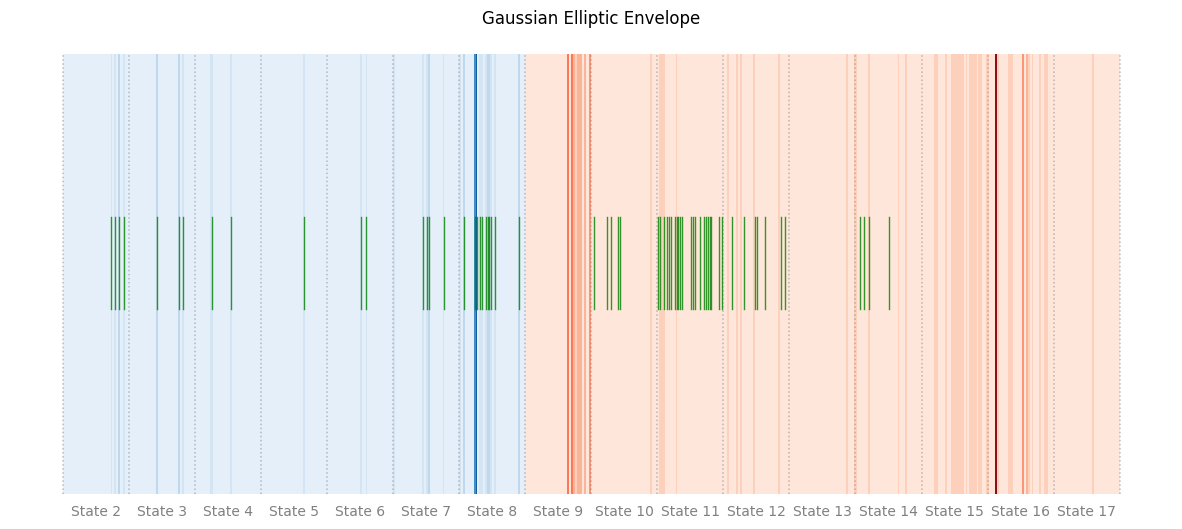

In [174]:
plot_colored_prog(slg, "Gaussian Elliptic Envelope")

576
17


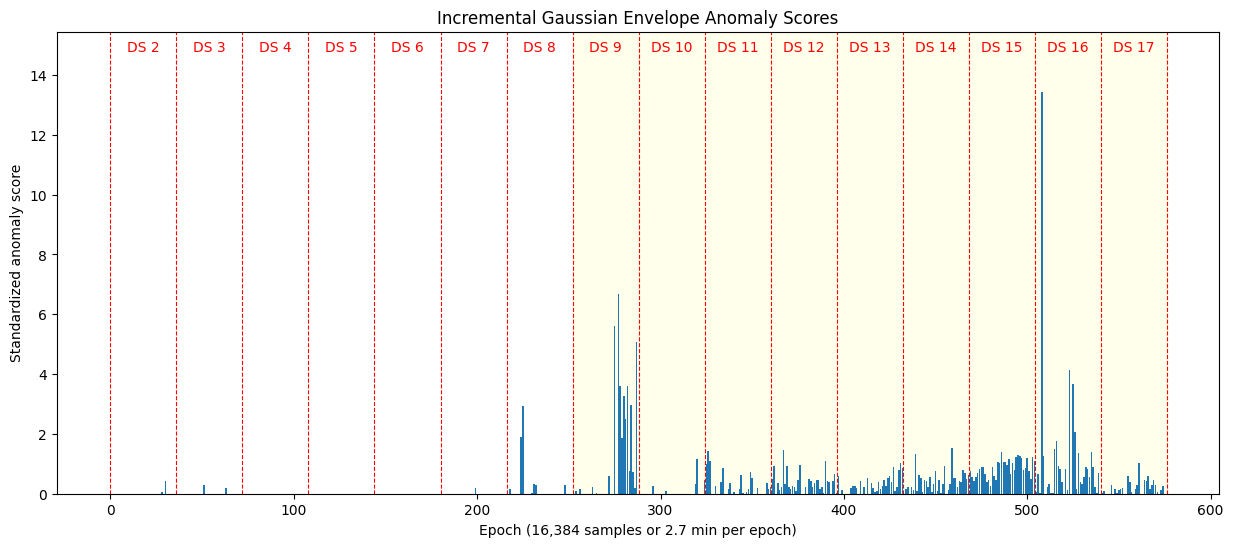

In [52]:
plot_anom(slg, "Incremental Gaussian Envelope Anomaly Scores")

### Online one class SVM

In [60]:
healthy_data_top.shape, damage_data_top.shape

((288, 3), (324, 3))

In [20]:
from sklearn.svm import OneClassSVM
from scipy.special import expit 

class IncrementalOneClassSVM:
    def __init__(self, buffer_size = 36, nu = 0.1, retrain_size=20):
        self.model = OneClassSVM(nu = nu, kernel='rbf')
        self.buffer_size = buffer_size
        self.retrain_size = retrain_size
        self.data_buffer = []
        self.support_vectors = None
        self.ctr = 0
        self.init_start = []
        np.random.seed(4)

    def initial_train(self, data):
        self.model.fit(data)
        self.support_vectors = self.model.support_vectors_

    def _buffer_data(self, new_data):
        self.data_buffer.extend(new_data)
        if self.ctr < 36:
            self.init_start.append(np.array(new_data).flatten())
            if self.ctr == 35:
                self.model.fit(np.array(self.init_start))
                self.support_vectors = self.model.support_vectors_

        elif len(self.data_buffer) > self.buffer_size:
            self._update_model()

    def _update_model(self):
        new_data = np.array(self.data_buffer)
        self.data_buffer = []

        # Filtering new data - select data significantly different from current support vectors
        # This is a simple distance-based filter for demonstration purposes
        distance = np.min(np.linalg.norm(new_data[:, np.newaxis] - self.support_vectors, axis=2), axis=1)
        significant_new_data = new_data[distance > np.percentile(distance, 50)]

        if len(significant_new_data) > 0:
            #combined_data = np.vstack([self.support_vectors, significant_new_data])
            #print(f"Orig. nbr of support vectors of {self.support_vectors.shape[0]}")
            support_vector_entries = min(int(0.50 * self.retrain_size), self.support_vectors.shape[0])  # 20% from support vectors
            #print(f"Sampled nbr of support vectors {support_vector_entries}") # show number of support vectors (usually around 10)
            new_data_entries = self.retrain_size - support_vector_entries  # remaining 80% from new data

            # Selecting entries
            selected_support_vectors = np.random.choice(self.support_vectors.shape[0], support_vector_entries, replace=False)
            selected_new_data = np.random.choice(significant_new_data.shape[0], min(new_data_entries, significant_new_data.shape[0]), replace=False)

            # Retrain model with a subset of the data
            subset_for_retraining = np.vstack([self.support_vectors[selected_support_vectors], significant_new_data[selected_new_data]])

            self.model.fit(subset_for_retraining)
            self.support_vectors = self.model.support_vectors_

    def update(self, new_data):
        """
        Add new data for training. This can be a single data point or multiple data points in a batch.
        """
        if isinstance(new_data, list) or len(new_data.shape) > 1:
            self._buffer_data(new_data)
        else:
            self._buffer_data([new_data]) 
        self.ctr += 1

    def predict(self, data):
        """
        Predict using the One-Class SVM model. 
        """
        if data.ndim == 1:
            data = np.array([data])
        return self.model.predict(data)
    
    def decision_function(self, data):
        """
        Pseudo-probabilistic predict using the One-Class SVM model. 
        """
        if data.ndim == 1:
            data = np.array([data])
        decision_function = self.model.decision_function(data)
        return decision_function
    
    def predict_proba(self, data):
        """
        Pseudo-probabilistic predict using the One-Class SVM model. 
        """
        if data.ndim == 1:
            data = np.array([data])
        decision_function = self.model.decision_function(data)
        return 1-expit(decision_function)

In [21]:
param_grid_occsvm = {
    'nu': [0.1, 0.2, 0.4, 0.75],
    'buffer_size': [18, 36, 72],
    'retrain_size': [10, 20, 40]
}

In [22]:
max_score = -10
memorize_params = {}
for nu in param_grid_occsvm['nu']:
    for buf_size in param_grid_occsvm['buffer_size']:
        for ret_size in param_grid_occsvm['retrain_size']:
            slsvc = StreamLearning(healthy_data_top, damage_data_top, IncrementalOneClassSVM(buffer_size=buf_size, nu = nu, retrain_size=ret_size))
            slsvc.cross_validate()
            avg_score = np.mean(slsvc.val_scores)
            if max_score < avg_score:
                max_score = avg_score
                memorize_params = {'nu': nu, 'buffer_size': buf_size, 'retrain_size': ret_size}

In [23]:
max_score, memorize_params

(0.9444444444444444, {'nu': 0.1, 'buffer_size': 18, 'retrain_size': 20})

In [24]:
slsvc = StreamLearning(healthy_data_top, damage_data_top, IncrementalOneClassSVM(**memorize_params), min_points_for_retraining=36, reset_clf=False)
slsvc.loop()
print_metrics(slsvc)

cor_d_preds 262 cor_h_preds (do not use) 273 d_pred_len 322 h_pred_len 288
fp count 39 first damage index 2


In [28]:
slsvc_reset = StreamLearning(healthy_data_top, damage_data_top, IncrementalOneClassSVM(**memorize_params), min_points_for_retraining=36, reset_clf=True)
slsvc_reset.loop()
print_metrics(slsvc_reset)

cor_d_preds 308 cor_h_preds (do not use) 231 d_pred_len 324 h_pred_len 288
fp count 76 first damage index 0


576
17


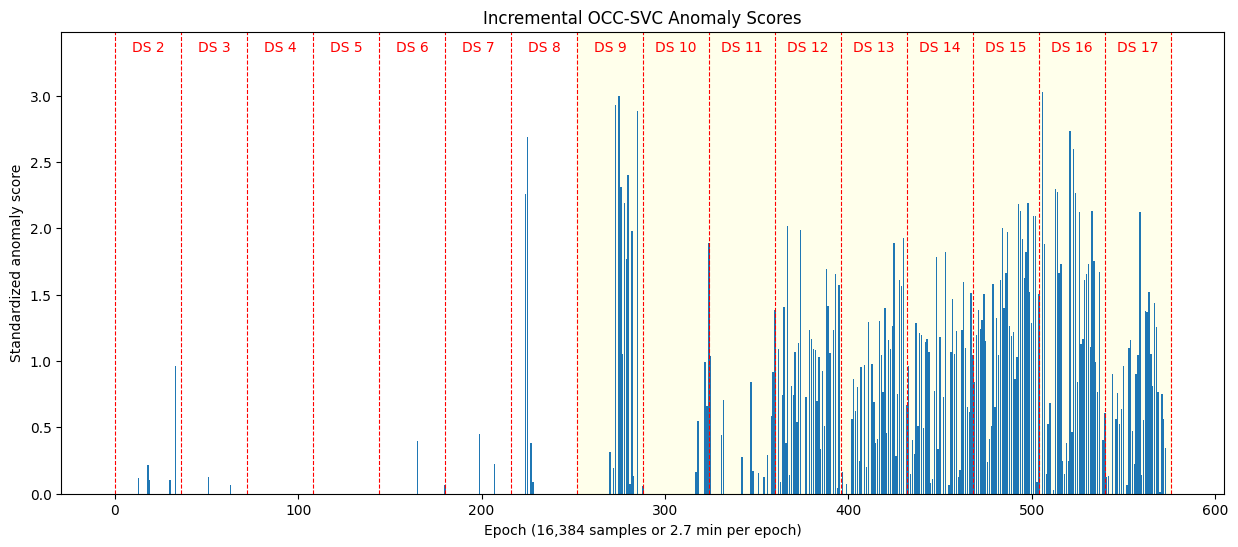

In [96]:
plot_anom(slsvc, "Incremental OCC-SVC Anomaly Scores")

In [25]:
def plot_decision_boundary(model, X_train, y_train):
    x = np.linspace(X_train[:,0].min()-1, X_train[:,0].max()+1, 50)
    y = np.linspace(X_train[:,1].min()-1, X_train[:,1].max()+1, 50)
    z = np.linspace(X_train[:,2].min()-1, X_train[:,2].max()+1, 50)
    xx, yy, zz = np.meshgrid(x, y, z)
    grid = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]

    # Evaluate the model's decision function
    decision_values = model.decision_function(grid)
    decision_signs = np.sign(decision_values).reshape(xx.shape)

    # Check for sign changes along each axis
    diff_x = np.diff(decision_signs, axis=0)
    diff_y = np.diff(decision_signs, axis=1)
    diff_z = np.diff(decision_signs, axis=2)

    # Combine the differences to locate boundary points
    boundary_mask = np.zeros_like(decision_signs, dtype=bool)
    boundary_mask[:-1,:,:] |= diff_x != 0
    boundary_mask[:,:-1,:] |= diff_y != 0
    boundary_mask[:,:,:-1] |= diff_z != 0

    boundary_points = grid[boundary_mask.ravel()]

    # Visualize the decision boundary
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the boundary points
    ax.scatter(boundary_points[:, 0], boundary_points[:, 1], boundary_points[:, 2], color='orange', s=8, alpha=0.5)
    ax.set_xlim((-4, 1))
    ax.set_ylim((-1, 6))
    ax.set_zlim((-5, 3))
    #ax.plot_surface(boundary_points[:, 0], boundary_points[:, 1], boundary_points[:, 2], color='orange', alpha=0.5)

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train, cmap=plt.cm.coolwarm, s=50)

    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')
    plt.title("3D Decision Boundary of OCC-SVC")
    plt.show()

In [ ]:
import matplotlib
matplotlib.use('Qt5Agg') 
plot_decision_boundary(slsvc.clf, np.vstack((healthy_data_top, damage_data_top)), np.hstack((np.full(healthy_data_top.shape[0], 0), np.full(damage_data_top.shape[0], 1))))
# this "useless" while loop is necessary since otherwise the next cell acquires an execution lock and this cell is marked as computed even if the plot does not appear on screen
# (seems to be a concurrency related problem)
i = 0
while True:
    i = i + 1
    i = i - 1

### Half space trees

In [24]:
from river import compose
from river import datasets
from river import metrics
from river import preprocessing

class IncrementalHalfSpace():
    def __init__(self, h_len, size = 36, n_trees = 70, height  = 3):
        self.hst = compose.Pipeline(preprocessing.MinMaxScaler(), 
                                    anomaly.HalfSpaceTrees(n_trees=n_trees, height=height, window_size=size, seed=42))
        self.ctr = 0
        self.an_sc = [] # anomaly scores 
        self.h_len = h_len # number of healthy data points to expect 

    def update(self, data):
        data = {f'x_{i}': val  for i, val in enumerate(data)}
        self.ctr += 1
        self.hst = self.hst.learn_one(data)

    def predict_proba(self, data):
        if data.ndim == 1:
            data = {f'x_{i}': val  for i, val in enumerate(data)}
            sc = self.hst.score_one(data)
            if self.ctr < self.h_len:
                self.an_sc.append(sc) # to find if an anomaly is in fact anomalous, we must have a (running) distribution of anomalies
            if len(self.an_sc)> 1:
                return [(sc - np.mean(self.an_sc))/np.std(self.an_sc)]
            else: 
                return [sc] 
        else:
            scores = []
            for el in data:
                inst = {f'x_{i}': val  for i, val in enumerate(el)}
                scores.append((self.hst.score_one(inst) - np.mean(self.an_sc))/np.std(self.an_sc)) 
            return scores
        
    def decision_function(self, data):
        return (self.predict_proba(data) - np.mean(self.an_sc))/np.std(self.an_sc)
        
    def predict(self, data):
        if data.ndim == 1:
            data = {f'x_{i}': val  for i, val in enumerate(data)}
            sc = self.hst.score_one(data)
            if 2*np.std(self.an_sc) < np.abs(sc - np.mean(self.an_sc)):
                return [-1]
            else:
                return [1]
        else:
            scores = []
            mu = np.mean(self.an_sc)
            sigma = np.std(self.an_sc)
            for el in data:
                inst = {f'x_{i}': val for i, val in enumerate(el)}
                sc = self.hst.score_one(inst)
                if sigma < np.abs(sc - mu):
                    scores.append(-1)
                else:
                    scores.append(1)
            return scores

In [25]:
param_grid_half = {
    'size': [9, 18, 36],
    'height': [3, 4],
    'n_trees': [10, 20, 30, 40, 50, 60, 70]
}

In [24]:
max_score = -10
memorize_params_half = {}
for size in param_grid_half['size']:
    for height in param_grid_half['height']:
        for n_trees in param_grid_half['n_trees']:
            slhst = StreamLearning(healthy_data_top, damage_data_top, IncrementalHalfSpace(healthy_data_top.shape[0], size = size, n_trees= n_trees, height=height), min_points_for_retraining=size)
            slhst.cross_validate()
            avg_score = np.mean(slhst.val_scores)
            if max_score < avg_score:
                max_score = avg_score
                memorize_params_half = {'size': size, 'height': height, 'n_trees': n_trees}

In [30]:
memorize_params_half, max_score

({'size': 36, 'height': 3, 'n_trees': 10}, 0.9087301587301587)

In [26]:
slhs = StreamLearning(healthy_data_top, damage_data_top,  IncrementalHalfSpace(h_len = healthy_data_top.shape[0], size = 36, height=3, n_trees=10), min_points_for_retraining=18)
slhs.loop()
print_metrics(slhs)

cor_d_preds 288 cor_h_preds (do not use) 247 d_pred_len 315 h_pred_len 288
fp count 16 first damage index 9


In [46]:
slhs = StreamLearning(healthy_data_top, damage_data_top, IncrementalHalfSpace(h_len = healthy_data_top.shape[0], **memorize_params_half), min_points_for_retraining=18, reset_clf=True)
slhs.loop()
print_metrics(slhs)

cor_d_preds 280 cor_h_preds (do not use) 174 d_pred_len 322 h_pred_len 288
fp count 10 first damage index 2


C:\Users\amroa\AppData\Local\Temp\ipykernel_23952\2591559262.py:26: RuntimeWarning: invalid value encountered in scalar divide
  return [(sc - np.mean(self.an_sc))/np.std(self.an_sc)]


576
17


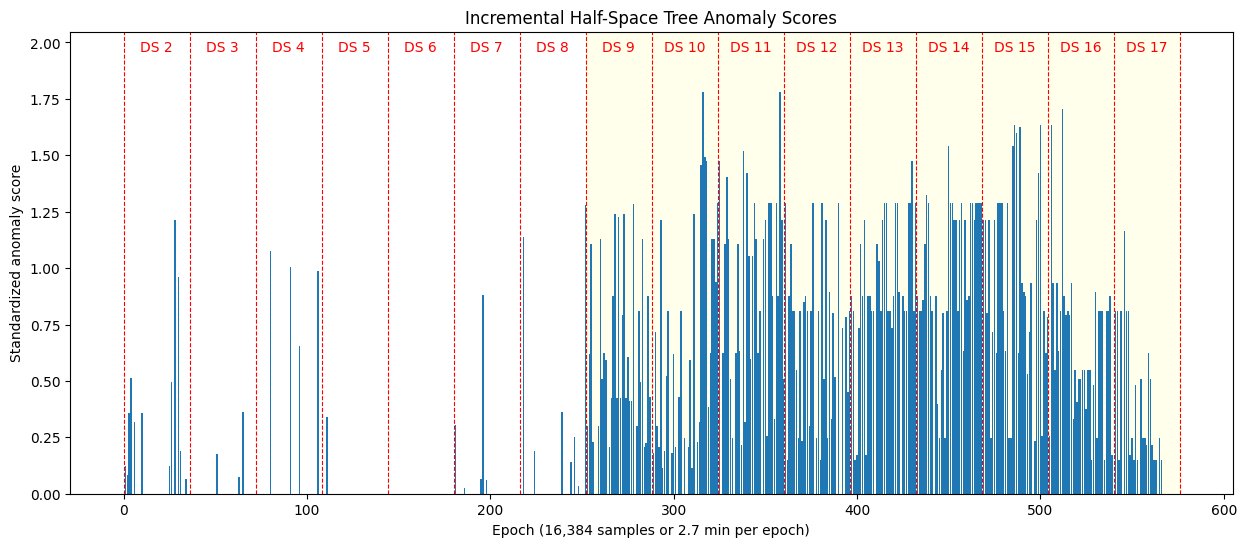

In [50]:
%matplotlib inline
plot_anom(slhs, "Incremental Half-Space Tree Anomaly Scores")

In [ ]:
import matplotlib
matplotlib.use('Qt5Agg') 
plot_decision_boundary(slhs.clf, np.vstack((healthy_data_top, damage_data_top)), np.hstack((np.full(healthy_data_top.shape[0], 0), np.full(damage_data_top.shape[0], 1))))

###  (Naive) Local outlier factor

In [38]:
from sklearn.neighbors import LocalOutlierFactor

class IncrementalLOF(): 
    def __init__(self, n_neighbors, max_size = 36):
        self.queue = []
        self.max_size = max_size # maximum size of the queue
        self.lof = LocalOutlierFactor(n_neighbors=n_neighbors, novelty=True)

    def update(self, new_point):
        self.queue.append(new_point)
        if len(self.queue) == self.max_size:
            self.lof.fit(self.queue)
            self.queue.pop(0)
        elif len(self.queue) > self.max_size:
            self.queue.pop(0)
    
    def predict_proba(self, points):
        if points.ndim == 1:
            points = np.array([points])
        return -self.lof.decision_function(points)
    
    def decision_function(self, points):
        return self.predict_proba(points)
    
    # unlike predict_proba, negative corresponds to an anomaly, positive to an inlier
    def predict(self, points):
        if points.ndim == 1:
            points = np.array([points])
        return self.lof.predict(points)

In [29]:
param_grid_lof_naive = {
    'max_size': [9, 18, 36],
    'n_neighbors': [3, 6, 12, 24] # must be smaller than max size
}

In [30]:
max_score = -10
param_grid_naive_lof = {}
for size in param_grid_lof_naive['max_size']:
    for neighbors in param_grid_lof_naive['n_neighbors']:
            if neighbors >= size:
                 continue
            slof = StreamLearning(healthy_data_top, damage_data_top, IncrementalLOF(n_neighbors=neighbors, max_size=size) , min_points_for_retraining=size)
            slof.cross_validate()
            avg_score = np.mean(slof.val_scores)
            if max_score < avg_score:
                max_score = avg_score
                memorize_params_lof = {'max_size': size, 'n_neighbors': neighbors}

In [31]:
max_score, memorize_params_lof

(0.9365079365079365, {'max_size': 18, 'n_neighbors': 12})

In [55]:
slof = StreamLearning(healthy_data_top, damage_data_top,  IncrementalLOF(**memorize_params_lof), min_points_for_retraining=18)
slof.loop()
print_metrics(slof)

cor_d_preds 274 cor_h_preds (do not use) 275 d_pred_len 324 h_pred_len 288
fp count 19 first damage index 0


In [33]:
slof = StreamLearning(healthy_data_top, damage_data_top,  IncrementalLOF(**memorize_params_lof), min_points_for_retraining=18, reset_clf=True)
slof.loop()
print_metrics(slof)

cor_d_preds 160 cor_h_preds (do not use) 284 d_pred_len 322 h_pred_len 288
fp count 19 first damage index 2


In [ ]:
matplotlib.use('Qt5Agg') 
plot_decision_boundary(slof.clf, np.vstack((healthy_data_top, damage_data_top)), np.hstack((np.full(healthy_data_top.shape[0], 0), np.full(damage_data_top.shape[0], 1))))
i = 0
while True:
    i = i + 1
    i = i - 1

576
17


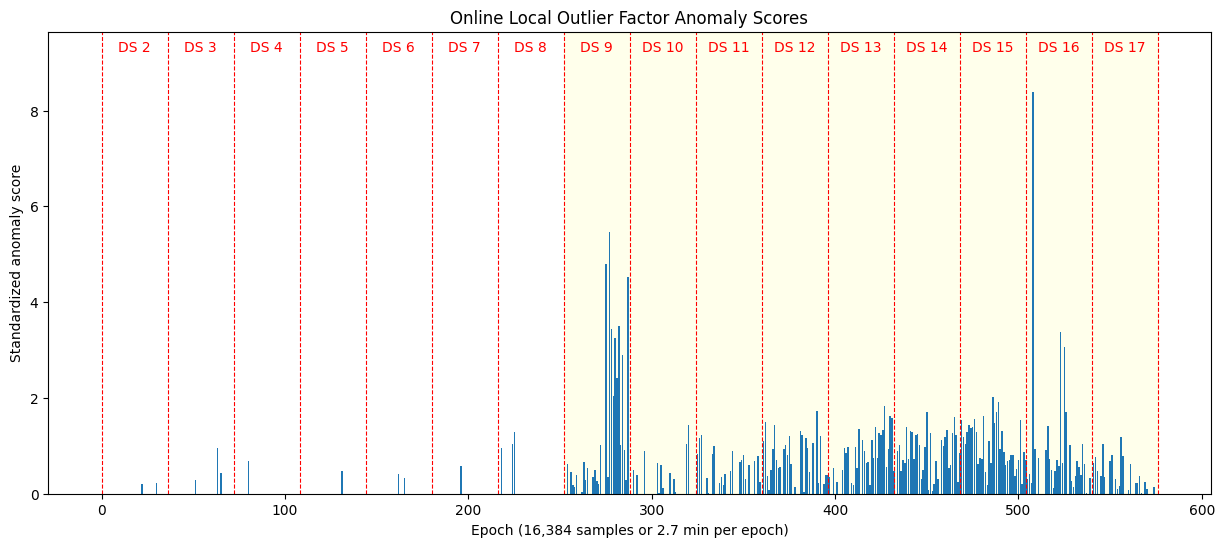

In [58]:
%matplotlib inline
plot_anom(slof, "Online Local Outlier Factor Anomaly Scores")

### LOF with non-decreasing density

In [278]:
# Re-importing necessary libraries and redefining the LOFWithLRD class
# as the code execution state has been reset.

import numpy as np
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor

class LOFWithLRD:
    def __init__(self, max_size = 36, n_neighbors=20):
        """
        Initialize the LOFWithLRD class.
        :param n_neighbors: number of neighbors to consider for LOF and LRD calculation.
        """
        self.n_neighbors = n_neighbors
        self.neighbors = None
        self.lrd = None
        self.max_size = max_size
        self.lof_scores = None
        self.queue = []
        self.prev_lrd = []
        self.cur_lrd = []
    
    def _euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))
    
    def update(self, new_point):
        self.lock = False
        self.queue.append(new_point)
        while (len(self.queue) > self.max_size):
            self.queue.pop(0)

    def reachability(self, distances, distances_to_new_point, points, indices_neighbors):
        kdistances = distances[indices_neighbors, -1]
        reachabilities = np.maximum(distances_to_new_point, kdistances)
        return reachabilities
    
    def calculate_lrd(self, nn_distances,  new_point):
        distances = np.array([self._euclidean_distance(new_point, point) for point in self.queue])
        neighbor_indices = (np.argsort(distances)[:self.n_neighbors]).astype(int)
        reachability = self.reachability(nn_distances, distances[neighbor_indices], self.queue, neighbor_indices)
        lrd = 1/np.mean(reachability)
        return lrd, neighbor_indices

    def predict_proba(self, new_point):
        if new_point.ndim == 1:
            new_point = np.array([new_point])
        scores = []
        for pt in new_point:
            # calculate nearest neighbors
            nn = NearestNeighbors(n_neighbors= self.n_neighbors).fit(self.queue)
            distances, _ = nn.kneighbors(self.queue)

            # get the nearest k neighbors of new point
            new_point_lrd, neighbor_indices = self.calculate_lrd(distances, pt)
            self.cur_lrd =  [self.calculate_lrd(distances, point)[0] for point in self.queue]
            if len(self.prev_lrd) == 0:
                self.true_lrd =self.cur_lrd
            else:
                if not self.lock:
                    self.prev_lrd.append(1000000)
                    self.prev_lrd.pop(0)
                    self.true_lrd = np.mean((self.prev_lrd, self.cur_lrd), axis = 0).tolist()
                    self.true_lrd[-1] = self.cur_lrd[-1]

            neighbor_lrd = [self.true_lrd[ni] for ni in neighbor_indices]
            self.prev_lrd = self.true_lrd
            scores.append(np.mean(neighbor_lrd)/new_point_lrd)
        self.lock = True
        return scores
    
    def predict(self, new_point):
        if new_point.ndim == 1:
            new_point = np.array([new_point])
        scores = []
        for pt in new_point:
            prob_pred = self.predict_proba(pt)[0]
            if prob_pred > 1.5:
                scores.append(-1)
            else:
                scores.append(1)
        return scores


In [268]:
param_grid_lof_mod = {
    'max_size': [9, 18, 36],
    'n_neighbors': [3, 6, 12, 24] # must be smaller than max size
}

In [281]:
slof = StreamLearning(healthy_data_top, damage_data_top,  LOFWithLRD(max_size=36, n_neighbors=24), min_points_for_retraining=36, reset_clf=False)
slof.loop()
print_metrics(slof)

cor_d_preds 206 cor_h_preds (do not use) 283 d_pred_len 322 h_pred_len 288
fp count 21 first damage index 2


In [279]:
max_score = -10
param_grid_lof = {}
for size in param_grid_lof_mod['max_size']:
    for neighbors in param_grid_lof_mod['n_neighbors']:
            if neighbors >= size:
                 continue
            slof = StreamLearning(healthy_data_top, damage_data_top, LOFWithLRD(max_size=size, n_neighbors=neighbors) , min_points_for_retraining=size)
            slof.cross_validate()
            avg_score = np.mean(slof.val_scores)
            if max_score < avg_score:
                max_score = avg_score
                memorize_params_lof = {'max_size': size, 'n_neighbors': neighbors}

In [280]:
memorize_params_lof, max_score
# output (for maximum in LRD: {'max_size': 18, 'n_neighbors': 12}, 0.9246031746031746)
# output (for minimum in LRD: {'max_size': 36, 'n_neighbors': 24}, 0.9761904761904763)

({'max_size': 36, 'n_neighbors': 24}, 0.9285714285714286)

### Entropy-guided elliptic envelopes

In [48]:
from river import active
from river import datasets
from river import linear_model
from river import metrics

class EntropyGuidedEnvelopes(): 
    def __init__(self, nu = 0.1, significance = 1, entropy_window=10):
        self.metric = metrics.Accuracy()
        self.base_model = linear_model.LogisticRegression(l2 = nu)
        self.model = active.EntropySampler(self.base_model, discount_factor=1, seed=42)
        self.envelopes = [IncrementalGaussianFitter()]
        self.last_entropies = []
        self.sig = significance
        self.last_two = [] # for stability of the Gaussian we need to keep the last 2 points
        self.entropy_window = entropy_window
    
    @staticmethod
    def calculate_entropy(y_pred):
        probabilities = y_pred
        entropy = -sum(p * np.log2(p) for p in probabilities.values() if p > 0)
        return entropy

    def update(self, data):
        data_dict = {f'x_{i}': val  for i, val in enumerate(data)}
        y_pred, ask = self.model.predict_proba_one(data_dict) 
        if ask:
            self.model.learn_one(data_dict, 0)
        entropy_cur = EntropyGuidedEnvelopes.calculate_entropy(y_pred)
        
        # make sure the size of our entropy queue does not exceed entropy_window
        if len(self.last_entropies) < self.entropy_window:
            self.last_entropies.append(entropy_cur)
            # fit the current gaussian fitter to it
            self.envelopes[-1].update(data)
        else:
            while len(self.last_entropies) != self.entropy_window:
                self.last_entropies.pop(0)
            # now size self.last_entropies contains entropy_window elements
            
            if entropy_cur > self.sig*np.std(self.last_entropies) + np.mean(self.last_entropies):
                # this entropy is with ~70% confidence much larger than previous entropies
                # hence, create a new envelope
                self.envelopes.append(IncrementalGaussianFitter())
                self.envelopes[-1].update(data)
                for pt in self.last_two:
                    self.envelopes[-1].update(pt)
            else:
                # this entropy is more or less the same as the previous, hence roughly the same distribution
                # --> belongs to the same envelope as the previous
                self.envelopes[-1].update(data)
            self.last_entropies.append(entropy_cur)

            # for stability of the Gaussian we need to keep the last 2 points
            self.last_two.append(data)
            while len(self.last_two) > 3:
                self.last_two.pop(0)

    def predict_proba(self, points):
        if points.ndim == 1:
            points = np.array([points])
        #print(self.envelopes[-1].count)
        return self.envelopes[-1].predict_proba(points)
    
    def decision_function(self, points):
        return self.predict_proba(points)
    
    def predict(self, points):
        if points.ndim == 1:
            points = np.array([points])
        return self.envelopes[-1].predict(points)

In [51]:
slen = StreamLearning(healthy_data_top, damage_data_top, EntropyGuidedEnvelopes(nu = 0.1, significance=3, entropy_window=10), min_points_for_retraining=3, reset_clf=False)
slen.loop()
print_metrics(slen)

cor_d_preds 312 cor_h_preds (do not use) 122 d_pred_len 324 h_pred_len 288
fp count 32 first damage index 0


In [44]:
param_grid_eng = {'nu': [0.1, 0.2, 0.4, 0.75], 'significance': [1, 2, 3, 4], 'entropy_window': [5, 10, 15, 20, 30]}

In [49]:
max_score = -10
memorize_params_eng = {}
for nu in param_grid_eng['nu']:
    for sig in param_grid_eng['significance']:
        for win in param_grid_eng['entropy_window']:
            sleng = StreamLearning(healthy_data_top, damage_data_top, EntropyGuidedEnvelopes(nu = nu, significance=sig, entropy_window=win) , min_points_for_retraining=3)
            sleng.cross_validate()
            avg_score = np.mean(sleng.val_scores)
            if max_score < avg_score:
                max_score = avg_score
                memorize_params_eng = {'nu': nu, 'significance': sig, 'entropy_window': win}

In [50]:
memorize_params_eng, max_score

({'nu': 0.1, 'significance': 3, 'entropy_window': 10}, 0.9246031746031746)

In [ ]:
matplotlib.use('Qt5Agg') 
plot_decision_boundary(slen.clf, np.vstack((healthy_data_top, damage_data_top)), np.hstack((np.full(healthy_data_top.shape[0], 0), np.full(damage_data_top.shape[0], 1))))

In [54]:
slen.clf.envelopes[-1].count, len(slen.clf.envelopes)

(7, 4)

576
17


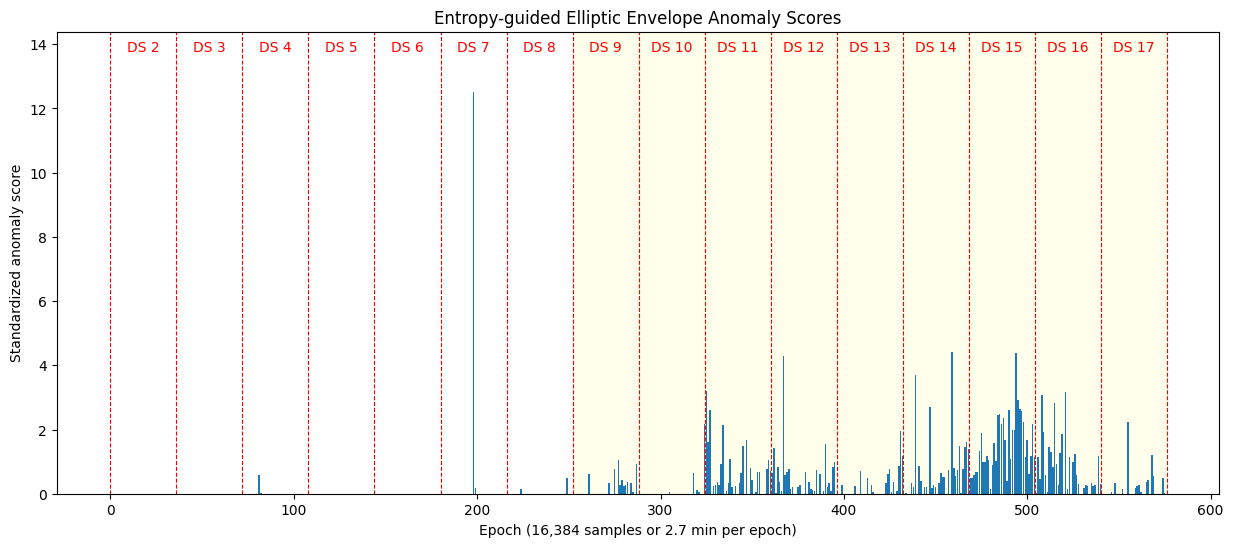

In [61]:
plot_anom(slen, "Entropy-guided Elliptic Envelope Anomaly Scores")

In [38]:
from river import metrics
from river import linear_model
from river import active

def calculate_entropy(y_pred):
    probabilities = y_pred
    entropy = -sum(p * np.log2(p) for p in probabilities.values() if p > 0)
    return entropy

X_river = [
    {f"feature_{i}": value for i, value in enumerate(sample)}
    for sample in np.vstack((healthy_data_top, damage_data_top))
]
y_river = np.hstack((np.zeros(len(healthy_data_top)), np.ones(len(damage_data_top)))).tolist() 

metric = metrics.Accuracy()
base_model = linear_model.LogisticRegression(l2 = 0.1)
model = active.EntropySampler(base_model, discount_factor=1, seed=42)
n_samples_used = 0
entropies = []

# Process each sample in the dataset
for i in range(len(X_river)):
    x = X_river[i]
    y_true = y_river[i]
    y_pred, ask = model.predict_proba_one(x) 
    entropy_cur = calculate_entropy(y_pred)
    entropies.append(entropy_cur)
    if ask:
        n_samples_used += 1
        model = model.learn_one(x, y_true)  # Learn from the true label

576
17


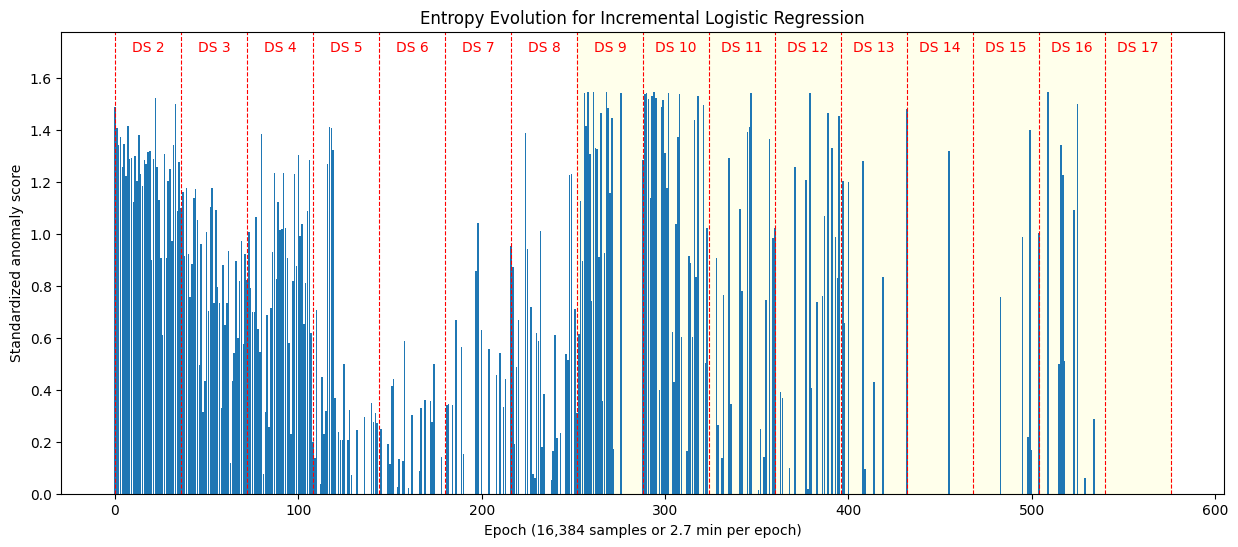

In [43]:
sns.reset_defaults()
sns.reset_orig()

plt.figure(figsize=(15, 6))
nbr_epochs = healthy_data_top.shape[0] - 36 + damage_data_top.shape[0]
print(nbr_epochs)

an_scores = np.hstack(entropies[36:]).reshape(-1, 1)
print(len(range(0, nbr_epochs+1, 36)))
for i in range(0, nbr_epochs+1, 36):
    plt.axvline(x=i, color='red', linestyle='--', linewidth=0.8)

# scale and plot the bars
sc = StandardScaler()
obs = np.arange(len(an_scores))
std_entropies = sc.fit_transform(an_scores).flatten()

plt.axvspan(36*7, 36*16, color='yellow', alpha=0.08)
plt.bar(obs, std_entropies)
plt.ylim(0, 1.15*max(std_entropies))

plt.xlabel('Epoch (16,384 samples or 2.7 min per epoch)')
plt.ylabel('Standardized anomaly score')
plt.title('Entropy Evolution for Incremental Logistic Regression')
text_pos = [i+18 for i in range(0, nbr_epochs, 36)]

# print title for each state
for idx, pos in enumerate(text_pos):
    str_capt =  f'DS {idx+2}'
    plt.text(pos, max(std_entropies)*1.1, str_capt, ha='center', color='red')

plt.show()